In [1]:
from sklearn import svm, metrics
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve

In [6]:
def svm_train(X, y, C=1.0, kernel='rbf', class_weight=None, degree=3, probability=False, verbose=False):
    svmc = svm.SVC(C=C, kernel=kernel, class_weight=class_weight, degree=degree, probability=probability, verbose=verbose,cache_size=2000)
    svmc.fit(X, y)
    return svmc

def get_classification_score(svmc, X, y):
    return svmc.score(X, y)

def get_f1_score(svmc, X, y, average='macro'):
    yp = svmc.predict(X)
    return metrics.f1_score(y, yp, average=average)


def plot_validation_curve(X, y, param_name, param_range, cross_validation=5, fig_name="validation_curve.png",
                          xscale='linear', scorer=None, kernel='rbf', C=1.0, class_weight=None):
    svmc = svm.SVC(kernel=kernel, C=C, class_weight=class_weight,cache_size=2000)
    tr_sc, tst_sc = model_selection.validation_curve(svmc, X, y, param_name=param_name,
                                                            param_range=param_range, cv=cross_validation, scoring=scorer, 
                                                     verbose=2, n_jobs=-1)
    plt.figure()
    plt.xticks(param_range)
    plt.xlabel(param_name)
    plt.xscale(xscale)
    plt.ylabel("Score")
    plt.plot(param_range, np.mean(tr_sc, axis=1), label='Training score')
    plt.plot(param_range, np.mean(tst_sc, axis=1), label='Cross-validation score')
    plt.legend(loc="best")
    plt.title('SVM - Validation Curve')
    
    plt.savefig(fig_name)
    plt.show()
    return tr_sc, tst_sc

## Phishing Website dataset analysis

In [4]:
from scipy.io.arff import loadarff 

raw_data = loadarff('Training Dataset.arff')
ph_data = pd.DataFrame(raw_data[0])
ph_data.head()

for var in ph_data.columns.values:
    ph_data[var] = pd.Categorical(ph_data[var])
    ph_data[var] = ph_data[var].cat.codes

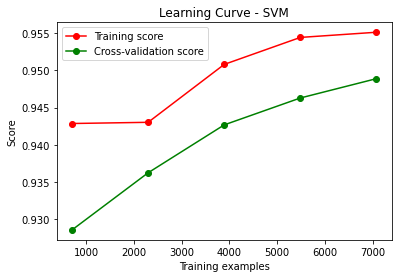

In [7]:
y = ph_data.Result.values
X = ph_data.drop(['Result'], axis=1)
fig, ax = plt.subplots()
ax.set_title("Learning Curve - SVM")
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
knn = svm_train(X_train, y_train)

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(knn, X_train, y_train, cv=5,
                       return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
ax.legend(loc="best")

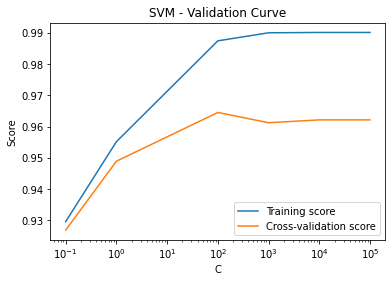

In [14]:
plot_validation_curve(X_train, y_train, 'C', [1e-1, 1, 100, 1000, 10000, 100000], 
                      fig_name="max_depth_vc.png", xscale='log'
                      , scorer=lambda svmc, x, y: get_classification_score(svmc, x, y))

Let us fix C at 100 and look at the performance of various kernels on the dataset. 


In [33]:
rbf_c100 = svm_train(X_train, y_train, C=100,probability=True)
get_classification_score(rbf_c100, X_test, y_test)

0.9715061058344641

In [34]:
lin_svm = svm_train(X_train, y_train, kernel='linear', C=100, probability=True)
get_classification_score(lin_svm, X_test, y_test)

0.9393939393939394

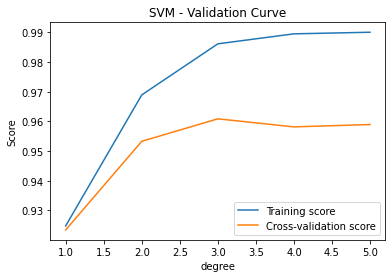

In [23]:
plot_validation_curve(X_train, y_train, 'degree', [1,2,3,4,5], 
                      fig_name="max_depth_vc.png", xscale='linear', kernel = "poly", C=100)

In [35]:
poly_svm = svm_train(X_train, y_train, kernel='poly', degree=3, C=100, probability=True)
get_classification_score(poly_svm, X_test, y_test)

0.9696969696969697

AUC curve to identify which of the above model classifies better. 

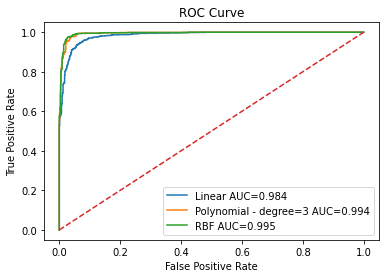

In [37]:
results = []
for name, model in [("Linear", lin_svm), ("Polynomial - degree=3", poly_svm), ("RBF", rbf_c100)]:
    fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba(X_test)[:, 1], pos_label=1)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=name + " AUC={:.3f}".format(auc))

plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

In [39]:
import pickle
pickle.dump(rbf_c100, open("RBF D2.sav", 'wb'))

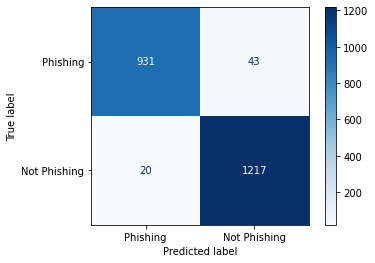

In [43]:
ax = plot_confusion_matrix(rbf_c100, X_test, y_test,
                                 display_labels=['Phishing',
                                 'Not Phishing'],cmap=plt.cm.Blues, values_format='d')
plt.show()

## Census Dataset Analysis

In [3]:
data = pd.read_csv("adult.data", sep='\t', header=None, 
                   names=["age", "workclass", "fnlwgt", "education", 
                          "education-num", "marital-status", "occupation",
                          "relationship", "race", "sex", "capital-gain", 
                          "capital-loss", "hours-per-week", "native-country", 
                          "output"])
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


<AxesSubplot:xlabel='output', ylabel='count'>

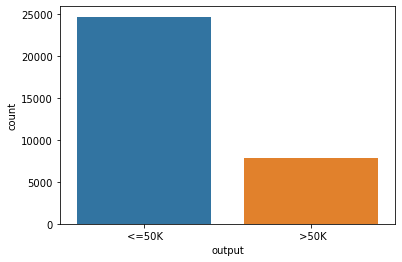

In [4]:
sns.countplot(x="output", data=data)

In [5]:
categorical_vars =["workclass", "education", "marital-status", "occupation", "relationship", 
                   "race", "sex", "native-country"]
df = data.copy()
for var in categorical_vars:
    df[var] = pd.Categorical(df[var])
    df[var] = df[var].cat.codes

continuous_vars = ["fnlwgt", "capital-gain", "capital-loss"]
for var in continuous_vars:
    df[var] = (df[var]-df[var].mean())/df[var].std()

y = df.output.values
X = df.drop(['output'], axis=1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output
0,39,7,-1.063594,9,13,4,1,1,4,1,0.148451,-0.216656,40,39,<=50K
1,50,6,-1.008692,9,13,2,4,0,4,1,-0.145918,-0.216656,13,39,<=50K
2,38,4,0.245075,11,9,0,6,1,4,1,-0.145918,-0.216656,40,39,<=50K
3,53,4,0.425795,1,7,2,6,0,2,1,-0.145918,-0.216656,40,39,<=50K
4,28,4,1.408154,9,13,2,10,5,2,0,-0.145918,-0.216656,40,5,<=50K


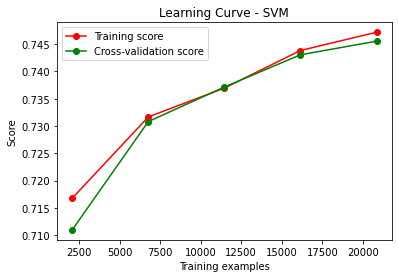

In [6]:
fig, ax = plt.subplots()
ax.set_title("Learning Curve - SVM")
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
knn = svm_train(X_train, y_train, class_weight="balanced")

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(knn, X_train, y_train, cv=5,
                       return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
ax.legend(loc="best")

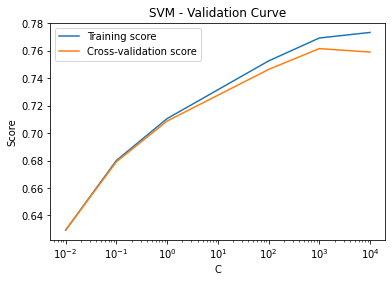

In [7]:
plot_validation_curve(X_train, y_train, 'C', [1e-2, 1e-1, 1, 100, 1000, 10000], 
                      fig_name="max_depth_vc.png", xscale='log',
                      class_weight="balanced", scorer=lambda svmc, x, y: get_f1_score(svmc, x, y))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
rbf_c1000 = svm_train(X_train, y_train, C=1000,probability=True, class_weight="balanced")
get_f1_score(rbf_c1000, X_test, y_test)

0.7556379771111352

In [ ]:
lin_svm = svm_train(X_train, y_train, kernel='linear', C=1000, probability=True, class_weight="balanced", verbose=True)
get_f1_score(rbf_c1000, X_test, y_test)

[LibSVM]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed: 10.6min remaining:  9.8min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 40.2min finished


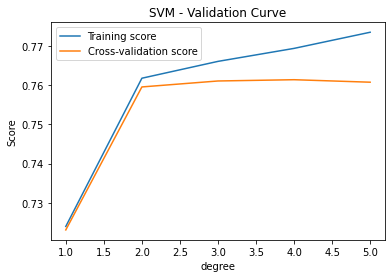

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
plot_validation_curve(X_train, y_train, 'degree', [1,2,3,4,5], 
                      fig_name="max_depth_vc.png", xscale='linear', kernel = "poly", C=1000, class_weight="balanced", 
                      scorer = lambda svmc, x, y: get_f1_score(svmc, x, y))

degree = 3.0 works well for polynomial kernel

In [8]:
poly_svm = svm_train(X_train, y_train, kernel='poly', degree=3, C=1000, probability=True)
get_f1_score(poly_svm, X_test, y_test)

0.7587307467342561

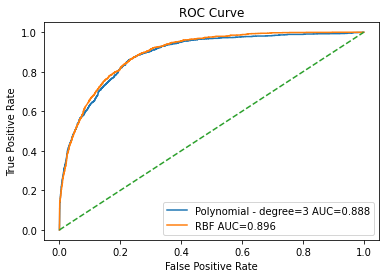

In [17]:
results = []
for name, model in [("Polynomial - degree=3", poly_svm), ("RBF", rbf_c1000)]:
    fpr, tpr, _ = metrics.roc_curve(y_test, model.predict_proba(X_test)[:, 1], pos_label=" >50K")
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=name + " AUC={:.3f}".format(auc))

plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

In [21]:
import pickle
pickle.dump(rbf_c1000, open("RBF D1.sav", 'wb'))

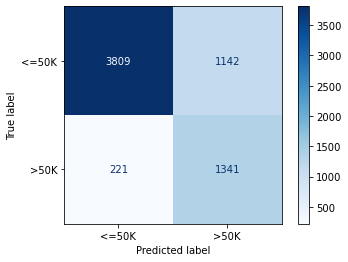

In [20]:
ax = plot_confusion_matrix(rbf_c1000, X_test, y_test,
                                 display_labels=['<=50K',
                                 '>50K'],cmap=plt.cm.Blues, values_format='d')
plt.show()